In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, rand_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from keras.models  import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
import glob
%matplotlib inline
pd.set_option('display.max_columns', None)
df = pd.read_csv('df_arabica_clean.csv')
#sweetness, defects, clean cup and uniformity all 10 for every row
# df = df.drop(columns=['ICO Number', 'Unnamed: 0', 'ID', 'Sweetness', 'Clean Cup', 'Defects', 'Uniformity'])
df = df.fillna('N/A')
rs = 12
df.head()

,Unnamed: 0,ID,Country of Origin,Farm Name,Lot Number,Mill,ICO Number,Company,Altitude,Region,Producer,Number of Bags,Bag Weight,In-Country Partner,Harvest Year,Grading Date,Owner,Variety,Status,Processing Method,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Overall,Defects,Total Cup Points,Moisture Percentage,Category One Defects,Quakers,Color,Category Two Defects,Expiration,Certification Body,Certification Address,Certification Contact
0,0,0,Colombia,Finca El Paraiso,CQU2022015,Finca El Paraiso,N/A,Coffee Quality Union,1700-1930,"Piendamo,Cauca",Diego Samuel Bermudez,1,35 kg,Japan Coffee Exchange,2021 / 2022,"September 21st, 2022",Coffee Quality Union,Castillo,Completed,Double Anaerobic Washed,8.58,8.50,8.42,8.58,8.25,8.42,10.0,10.0,10.0,8.58,0.0,89.33,11.8,0,0,green,3,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
1,1,1,Taiwan,Royal Bean Geisha Estate,"The 2022 Pacific Rim Coffee Summit,T037",Royal Bean Geisha Estate,N/A,Taiwan Coffee Laboratory,1200,Chiayi,曾福森,1,80 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021 / 2022,"November 15th, 2022",Taiwan Coffee Laboratory 台灣咖啡研究室,Gesha,Completed,Washed / Wet,8.50,8.50,7.92,8.00,7.92,8.25,10.0,10.0,10.0,8.50,0.0,87.58,10.5,0,0,blue-green,0,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
2,2,2,Laos,OKLAO coffee farms,"The 2022 Pacific Rim Coffee Summit,LA01",oklao coffee processing plant,N/A,Taiwan Coffee Laboratory,1300,Laos Borofen Plateau,WU TAO CHI,19,25 kg,Taiwan Coffee Laboratory 台灣咖啡研究室,2021 / 2022,"November 15th, 2022",Taiwan Coffee Laboratory 台灣咖啡研究室,Java,Completed,Semi Washed,8.33,8.42,8.08,8.17,7.92,8.17,10.0,10.0,10.0,8.33,0.0,87.42,10.4,0,0,yellowish,2,"November 15th, 2023",Taiwan Coffee Laboratory 台灣咖啡研究室,"QAHWAH CO., LTD 4F, No. 225, Sec. 3, Beixin Rd...","Lin, Jen-An Neil 林仁安 - 886-289116612"
3,3,3,Costa Rica,La Cumbre,CQU2022017,La Montana Tarrazu MIll,N/A,Coffee Quality Union,1900,"Los Santos,Tarrazu",Santa Maria de Dota,1,22 kg,Japan Coffee Exchange,2022,"September 21st, 2022",Coffee Quality Union,Gesha,Completed,Washed / Wet,8.08,8.17,8.17,8.25,8.17,8.08,10.0,10.0,10.0,8.25,0.0,87.17,11.8,0,0,green,0,"September 21st, 2023",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901
4,4,4,Colombia,Finca Santuario,CQU2023002,Finca Santuario,N/A,Coffee Quality Union,1850-2100,"Popayan,Cauca",Camilo Merizalde,2,24 kg,Japan Coffee Exchange,2022,"March 6th, 2023",Coffee Quality Union,Red Bourbon,Completed,"Honey,Mossto",8.33,8.33,8.08,8.25,7.92,7.92,10.0,10.0,10.0,8.25,0.0,87.08,11.6,0,2,yellow-green,2,"March 5th, 2024",Japan Coffee Exchange,"〒413-0002 静岡県熱海市伊豆山１１７３−５８ 1173-58 Izusan, Ata...",松澤 宏樹 Koju Matsuzawa - +81(0)9085642901


In [76]:
numCountries = len(df['Country of Origin'].value_counts())

flavMetrics = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']
keepCols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Country of Origin']
scoreCols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance']

df = df[keepCols]

# sns.pairplot(df, hue='Country of Origin')

# drop outlier with moisture percentage of 0
# df = df.loc[df['Moisture Percentage'] > 0]

# converts scores out of 10 to 0-1 scale
for i in scoreCols:
    df[i] = df[i].apply(lambda x: x / 10.0)

# converts moisture percentage to 0-1 scale
# df['Moisture Percentage'] = df['Moisture Percentage'].apply(lambda x: x / 100.0)

X = df.drop(columns='Country of Origin')
y = pd.get_dummies(df['Country of Origin'])

countries = y.columns

print(countries)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)

Index(['Brazil', 'Colombia', 'Costa Rica', 'El Salvador', 'Ethiopia',
       'Guatemala', 'Honduras', 'Indonesia', 'Kenya', 'Laos', 'Madagascar',
       'Mexico', 'Myanmar', 'Nicaragua', 'Panama', 'Peru', 'Taiwan',
       'Tanzania, United Republic Of', 'Thailand', 'Uganda',
       'United States (Hawaii)', 'Vietnam'],
      dtype='object')


/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/1000
5/5 [==============================] - 1s 58ms/step - loss: 0.7805 - accuracy: 0.0194 - val_loss: 0.7571 - val_accuracy: 0.0192
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.7456 - accuracy: 0.0194 - val_loss: 0.7273 - val_accuracy: 0.0192
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.7179 - accuracy: 0.0194 - val_loss: 0.7030 - val_accuracy: 0.0192
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6950 - accuracy: 0.0194 - val_loss: 0.6824 - val_accuracy: 0.0192
Epoch 5/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6753 - accuracy: 0.0129 - val_loss: 0.6643 - val_accuracy: 0.0192
Epoch 6/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6578 - accuracy: 0.0194 - val_loss: 0.6478 - val_accuracy: 0.0192
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6416 - accuracy: 0.0194 - val_loss: 0.6324 - val_accuracy: 0.0385
Epoch 8/1000


<Axes: >

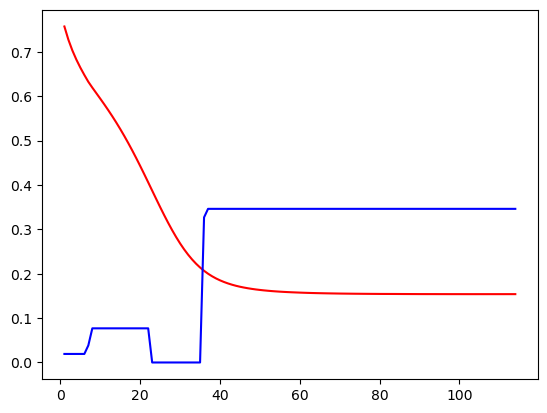

In [77]:
es = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10)

model1 = Sequential([
    Dense(6, input_shape=(6,), activation='relu'),
    Dense(12, activation='relu'),
    Dense(22, activation='softmax')
])

model1.compile(SGD(lr = .05), 'binary_crossentropy', metrics=['accuracy'])
hist1 = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[es])

val_losses = hist1.history['val_loss']
val_accuracies = hist1.history['val_accuracy']
epochs = range(1, len(val_losses) + 1)

sns.lineplot(x=epochs, y=val_losses, color='red')
sns.lineplot(x=epochs, y=val_accuracies, color='blue')

Epoch 1/1000


/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


5/5 [==============================] - 2s 51ms/step - loss: 0.7033 - accuracy: 0.0194 - val_loss: 0.6960 - val_accuracy: 0.0000e+00
Epoch 2/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6899 - accuracy: 0.0194 - val_loss: 0.6833 - val_accuracy: 0.0000e+00
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6772 - accuracy: 0.0194 - val_loss: 0.6710 - val_accuracy: 0.0000e+00
Epoch 4/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.6651 - accuracy: 0.0194 - val_loss: 0.6600 - val_accuracy: 0.0000e+00
Epoch 5/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6545 - accuracy: 0.0194 - val_loss: 0.6497 - val_accuracy: 0.0000e+00
Epoch 6/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.6440 - accuracy: 0.0194 - val_loss: 0.6392 - val_accuracy: 0.0000e+00
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.6331 - accuracy: 0.0194 - val_loss: 0.6282 - val_accuracy: 0.0000e+0

<Axes: >

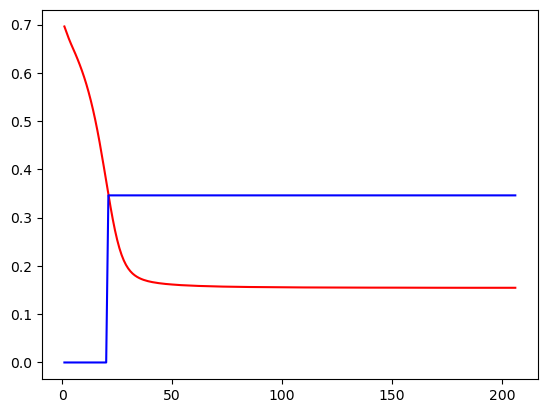

In [78]:

es = keras.callbacks.EarlyStopping(restore_best_weights=True, patience=10)
model2 = Sequential([
    Dense(6, input_shape=(6,), activation='relu'),
    Dense(12, activation='relu'),
    Dense(24, activation='relu'),
    Dense(22, activation='softmax')
])

model2.compile(SGD(lr = .05), 'binary_crossentropy', metrics=['accuracy'])
hist2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, callbacks=[es])

val_losses = hist2.history['val_loss']
val_accuracies = hist2.history['val_accuracy']
epochs = range(1, len(val_losses) + 1)

sns.lineplot(x=epochs, y=val_losses, color='red')
sns.lineplot(x=epochs, y=val_accuracies, color='blue')

ValueError: in user code:

    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/derek/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 277, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_36" "                 f"(type Sequential).
    
    Input 0 of layer "dense_112" is incompatible with the layer: expected axis -1 of input shape to have value 6, but received input with shape (None, 1)
    
    Call arguments received by layer "sequential_36" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None
